In [4]:

import pandas as pd

In [5]:
df_train = pd.read_csv('00_train_10_V2.csv')
df_test = pd.read_csv('00_test_10_V2.csv')
df_validation = pd.read_csv('00_validation_10_V2.csv')

In [1]:
import numpy as np
import pandas as pd
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization

# --- Chargement et prétraitement des données ---

def parse_cell(cell):
    return np.array(ast.literal_eval(cell), dtype=np.int32)

def df_to_tensor(df, input_cols=8):
  
    X = df.iloc[:, :input_cols].values.reshape(-1, input_cols, 1) 

    y = df['y'].values.reshape(-1, 1)  
    return X, y

# Charge les CSV (adapter les chemins si besoin)
df_train = pd.read_csv('00_train_V3_Ludwig van Beethoven_8_temps2.csv')
df_val = pd.read_csv('00_validation_V3_Ludwig van Beethoven_8_temps2.csv')
df_test = pd.read_csv('00_test_V3_Ludwig van Beethoven_8_temps2.csv')

X_train, y_train = df_to_tensor(df_train)
X_val, y_val = df_to_tensor(df_val)
X_test, y_test = df_to_tensor(df_test)

# --- Définition du modèle ---

model = Sequential([
    Input(shape=(8, 1)),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# --- Entraînement ---
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 20928.7617 - val_loss: 12460.7725
Epoch 2/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 13377.1826 - val_loss: 12433.2041
Epoch 3/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 13317.1191 - val_loss: 12412.1641
Epoch 4/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 13344.4521 - val_loss: 12494.0996
Epoch 5/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 13339.5244 - val_loss: 12424.0059
Epoch 6/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 13380.8076 - val_loss: 12483.3770
Epoch 7/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 13307.5225 - val_loss: 12515.5020
Epoch 8/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - loss: 13311.5947 - val_loss: 12449.5469
Epoch 9/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 13311.3945 - val_loss: 12392.5225
Epoch 10/50
12184/12184 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 13325.8223 - val_loss: 12480.2998
Epoch 11/

In [2]:
import numpy as np

def generate_sequence(model, seed_sequence=X_test[0].flatten().tolist(), length=50, noise_std=0.0):
    generated = list(seed_sequence)

    for _ in range(length):
        input_seq = np.array(generated[-8:]).reshape(1, 8, 1)
        pred = model.predict(input_seq, verbose=0)[0, 0]

        # Ajout d'un petit bruit optionnel pour varier
        if noise_std > 0.0:
            pred += np.random.normal(0, noise_std)

        # On arrondit et cast en int pour rester cohérent avec les données
        next_val = int(round(pred))
        generated.append(next_val)

    return generated
generated = generate_sequence(model, length=50, noise_std=2.0)
generated

[386,
 52,
 52,
 52,
 52,
 52,
 52,
 380,
 164,
 169,
 164,
 172,
 170,
 184,
 194,
 199,
 196,
 201,
 194,
 195,
 200,
 195,
 198,
 200,
 194,
 200,
 196,
 197,
 198,
 196,
 197,
 196,
 197,
 198,
 196,
 199,
 199,
 197,
 197,
 198,
 196,
 202,
 197,
 196,
 199,
 200,
 197,
 196,
 199,
 198,
 197,
 197,
 197,
 197,
 197,
 198,
 198,
 201]

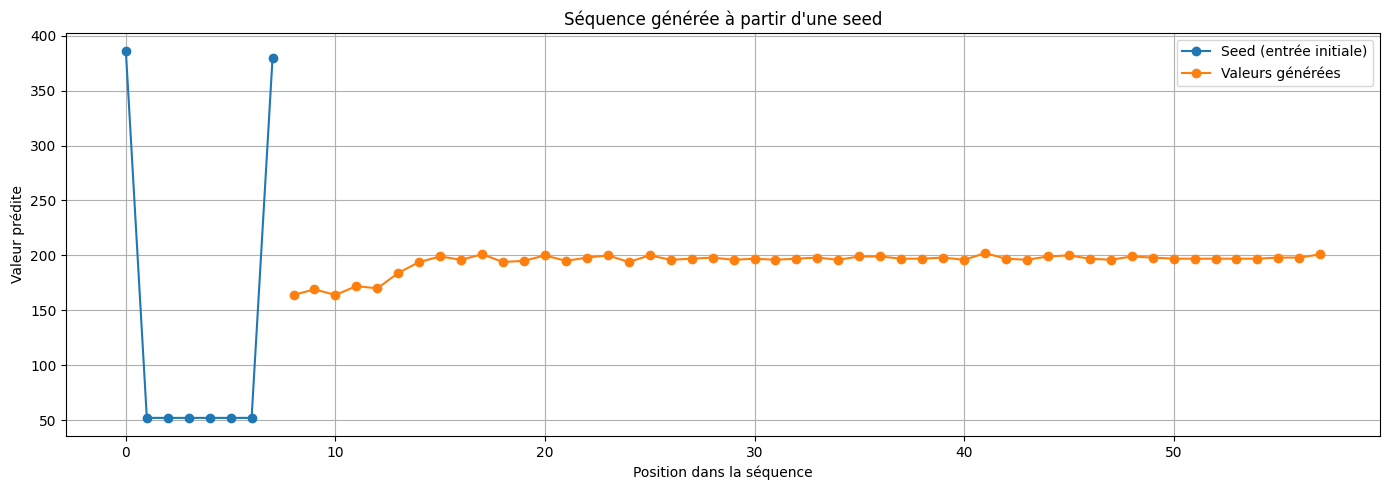

In [3]:
import matplotlib.pyplot as plt
seed = X_test[0]
plt.figure(figsize=(14, 5))
plt.plot(range(len(seed)), seed, label='Seed (entrée initiale)', marker='o')
plt.plot(range(len(seed), len(generated)), generated[len(seed):], label='Valeurs générées', marker='o')
plt.title("Séquence générée à partir d'une seed")
plt.xlabel("Position dans la séquence")
plt.ylabel("Valeur prédite")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
def generate_int_sequence(model, seed_sequence, num_preds=50):
    generated = []
    current_sequence = seed_sequence.copy()  # (200, 1)

    for _ in range(num_preds):
        pred = model.predict(np.expand_dims(current_sequence, axis=0), verbose=0)
        pred_note = int(np.round(pred[0][0]))  # <--- un seul int
        generated.append(pred_note)

        # Met à jour la séquence
        next_note = np.array([[pred_note]])  # (1, 1)
        current_sequence = np.vstack([current_sequence[1:], next_note])  # (200, 1)

    return generated


In [6]:
seed = X_test[0]  # (200, 1)
generated_sequence = generate_int_sequence(model, seed, num_preds=50)
generated_sequence

[274,
 273,
 270,
 269,
 267,
 259,
 273,
 272,
 272,
 271,
 271,
 272,
 271,
 273,
 273,
 273,
 273,
 273,
 273,
 273,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274,
 274]

In [8]:
seed = X_test[0]  # (200, 1)
generated_sequence = generate_int_sequence(model, seed, num_preds=50)

for i, note in enumerate(generated_sequence):
    print(f"Note {i+1:02d} :", note)


Note 01 : 117
Note 02 : 111
Note 03 : 114
Note 04 : 112
Note 05 : 113
Note 06 : 112
Note 07 : 113
Note 08 : 112
Note 09 : 113
Note 10 : 113
Note 11 : 113
Note 12 : 113
Note 13 : 113
Note 14 : 113
Note 15 : 113
Note 16 : 113
Note 17 : 113
Note 18 : 113
Note 19 : 113
Note 20 : 113
Note 21 : 113
Note 22 : 113
Note 23 : 113
Note 24 : 113
Note 25 : 113
Note 26 : 113
Note 27 : 113
Note 28 : 113
Note 29 : 113
Note 30 : 113
Note 31 : 113
Note 32 : 113
Note 33 : 113
Note 34 : 113
Note 35 : 113
Note 36 : 113
Note 37 : 113
Note 38 : 113
Note 39 : 113
Note 40 : 113
Note 41 : 113
Note 42 : 113
Note 43 : 113
Note 44 : 113
Note 45 : 113
Note 46 : 113
Note 47 : 113
Note 48 : 113
Note 49 : 113
Note 50 : 113


### test 2

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

n_classes = df_train['y'].nunique()

model = Sequential([
    Input(shape=(200, 1)),
    LSTM(256),
    Dense(173, activation='relu'),
    Dense(n_classes, activation='softmax')  # classification
])

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\ccdeb\AppData\Local\Temp\ipykernel_27812\2266279025.py", line 13, in <module>

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\trainer.py", line 60, in train_step

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\compile_utils.py", line 690, in __call__

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\compile_utils.py", line 699, in call

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py", line 33, in call

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\losses\losses.py", line 2246, in sparse_categorical_crossentropy

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\ops\nn.py", line 1964, in sparse_categorical_crossentropy

  File "C:\Users\ccdeb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\backend\tensorflow\nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 228 which is outside the valid range of [0, 173).  Label values: 111 111 166 94 5 141 170 201 153 160 150 150 167 153 146 93 22 93 167 102 228 102 159 160 93 179 150 46 44 44 170 50
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_57404]

In [10]:
def generate_class_sequence(model, seed_sequence, num_preds=50):
    generated = []
    current_sequence = seed_sequence.copy()

    for _ in range(num_preds):
        pred = model.predict(np.expand_dims(current_sequence, axis=0), verbose=0)
        pred_class = np.argmax(pred[0])  # on prend la classe prédite
        generated.append(pred_class)

        # Mise à jour de la séquence
        next_note = np.array([[pred_class]])  # (1, 1)
        current_sequence = np.vstack([current_sequence[1:], next_note])  # (200, 1)

    return generated


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Chargement des CSV
df_train = pd.read_csv('00_train_50_V8.csv')
df_test = pd.read_csv('00_test_50_V8.csv')
df_validation = pd.read_csv('00_validation_50_V8.csv')

# Définir correctement le nombre de classes
n_classes = df_train['y'].max() + 1  # ✅ Assure que la dernière couche a la bonne taille

# Préparer les données
X_train = np.stack(df_train.drop(columns='y').values).astype(np.float32)
y_train = df_train['y'].values.astype(np.int32)

X_val = np.stack(df_validation.drop(columns='y').values).astype(np.float32)
y_val = df_validation['y'].values.astype(np.int32)

# Adapter la forme pour LSTM (batch_size, timesteps, features)
X_train = X_train.reshape((-1, 200, 1))
X_val = X_val.reshape((-1, 200, 1))

# Modèle
model = Sequential([
    Input(shape=(200, 1)),
    LSTM(256),
    Dense(173, activation='relu'),  # Tu peux le changer si tu veux
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Entraînement
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)


Epoch 1/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 1053s 129ms/step - accuracy: 0.0666 - loss: 4.8479 - val_accuracy: 0.0566 - val_loss: 4.8566
Epoch 2/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 1057s 130ms/step - accuracy: 0.0783 - loss: 4.6239 - val_accuracy: 0.0599 - val_loss: 4.8671
Epoch 3/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 1046s 128ms/step - accuracy: 0.0863 - loss: 4.5463 - val_accuracy: 0.0587 - val_loss: 4.8438
Epoch 4/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 929s 114ms/step - accuracy: 0.0940 - loss: 4.4762 - val_accuracy: 0.0576 - val_loss: 4.8838
Epoch 5/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 902s 111ms/step - accuracy: 0.0979 - loss: 4.4292 - val_accuracy: 0.0622 - val_loss: 4.8903
Epoch 6/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 807s 99ms/step - accuracy: 0.1007 - loss: 4.3965 - val_accuracy: 0.0605 - val_loss: 4.9049
Epoch 7/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 856s 105ms/step - accuracy: 0.1048 - loss: 4.3557 - val_accuracy: 0.0607 - val_loss: 4.9088
Epoch 8/50
8144/8144 ━━━━━━━━━━━━━━━━━━━━ 893s 110ms/step - 

In [3]:
import random
import numpy as np

# Choisir une séquence de départ aléatoire depuis les données d'entraînement
start_idx = random.randint(0, X_train.shape[0] - 1)
seed_sequence = X_train[start_idx].copy()  # shape: (200, 1)

# Stocker les 50 prédictions
generated = []

# Génération d'une séquence de 50 entiers
for _ in range(100):
    input_seq = seed_sequence.reshape(1, 200, 1)  # (1, 200, 1)
    prediction = model.predict(input_seq, verbose=0)
    next_note = np.argmax(prediction)
    generated.append(next_note)
    
    # Mettre à jour la seed : enlever le premier, ajouter le nouveau à la fin
    seed_sequence = np.append(seed_sequence[1:], [[next_note]], axis=0)

print("Séquence générée :", generated)



Séquence générée : [39, 39, 39, 39, 39, 39, 39, 39, 165, 64, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242, 242]


In [4]:
df_gen = pd.DataFrame({"sequence":generated})
df_gen.to_csv('XX_generated_v2_50.csv')